# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Load Data

Let us start by importing relevant packages and libaries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
# Download SpaCy and import SpaCy
# ! python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
# Check package versions

# pd.show_versions(as_json = False)

In [4]:
# Load data
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Preparing features (`X`) & target (`y`)

In [5]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [6]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

## Data Exploration

Let us explore the data a bit more to get a feeling how to handle it and identify possible difficulties.

In [7]:
# Identify null values

data.isnull().sum()

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
Recommended IND            0
dtype: int64

There are no null values.

In [8]:
# Generate descriptive statistic 
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

data.describe()

,Clothing ID,Age,Positive Feedback Count,Recommended IND
count,18442.000000,18442.000000,18442.000000,18442.000000
mean,954.896757,43.383635,2.697484,0.816235
std,141.571783,12.246264,5.942220,0.387303
min,2.000000,18.000000,0.000000,0.000000
25%,863.000000,34.000000,0.000000,1.000000
50%,952.000000,41.000000,1.000000,1.000000
75%,1078.000000,52.000000,3.000000,1.000000
max,1205.000000,99.000000,122.000000,1.000000


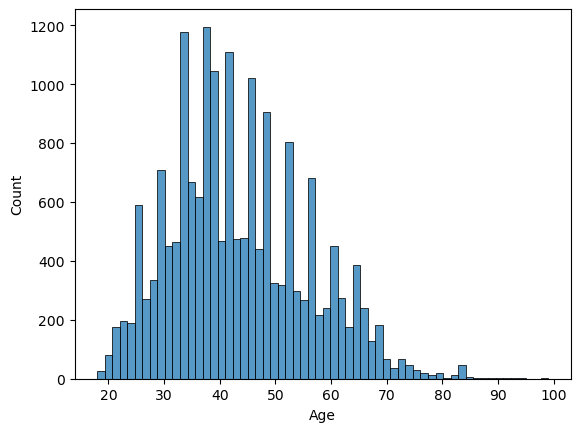

In [9]:
# Distribution of the numerical data Age 
# https://seaborn.pydata.org/generated/seaborn.histplot.html

age_dist = sns.histplot(data=data, x="Age")
plt.show()

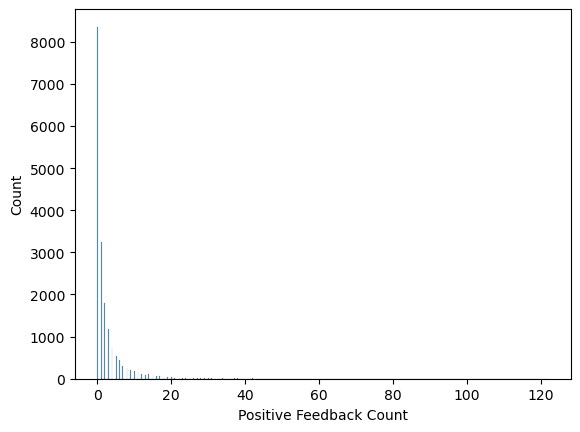

In [10]:
# Distribution of the numerical data Positive Feedback Count

feedback_dist = sns.histplot(data=data, x="Positive Feedback Count")
plt.show()

In [11]:
# Distribution of the categorical data
# Column Division Name

data["Division Name"].unique()

array(['General', 'General Petite'], dtype=object)

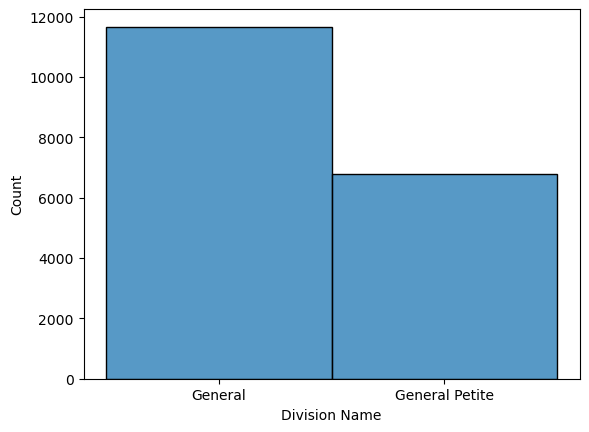

In [12]:
division_dist = sns.histplot(data=data, x="Division Name")
plt.show()

In [13]:
# Column Department Name

data["Department Name"].unique()

array(['Dresses', 'Bottoms', 'Tops', 'Jackets', 'Trend', 'Intimate'],
      dtype=object)

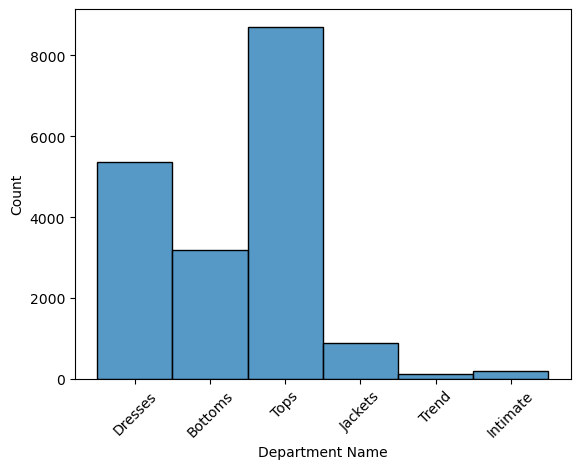

In [14]:
# https://stackoverflow.com/questions/26540035/rotate-label-text-in-seaborn

class_dist = sns.histplot(data=data, x="Department Name")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

In [15]:
# Column Class Name

data["Class Name"].unique()

array(['Dresses', 'Pants', 'Blouses', 'Knits', 'Outerwear', 'Sweaters',
       'Skirts', 'Fine gauge', 'Jackets', 'Trend', 'Lounge', 'Jeans',
       'Shorts', 'Casual bottoms'], dtype=object)

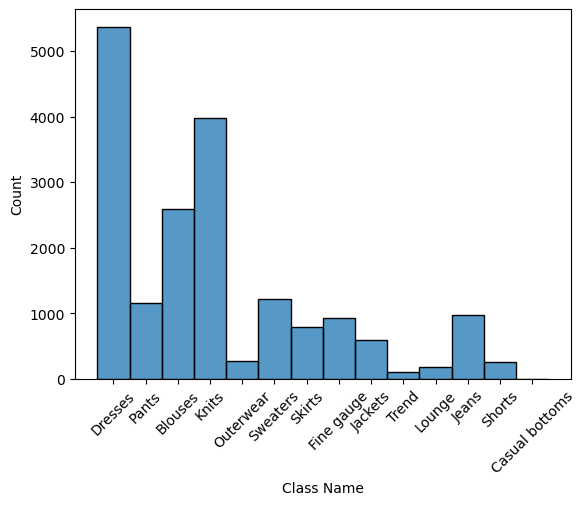

In [16]:
class_dist = sns.histplot(data=data, x="Class Name")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

The data consits of numerical, categorical and text data. I decide just work with the following features

- Numerical: `Age`, `Positive Feedback Count`
- Categorical: `Division Name`, `Department Name`, `Class Name`
- Text: `Review Text `

Variable `Clothing ID` is just a counter and ist seems that `Title` do not offer more information than the `Review Text`.

There are no null values.

## Building Pipeline

After the Data Exploration, let us build a pipeline. The main steps are **preprocess** and **combine** the pipeline.

### Preprocess the Pipeline

#### Splitting Numerical, Categorical, and Text Data

Split the data and define feature groups:

- Numerical: `num_features`
- Categorical: `cat_features`
- Text: `text_features`

In [17]:
# `num_features`

num_features = (
    X[[
        'Age',
        'Positive Feedback Count',     
    ]].columns
)
print('Numerical features:', num_features)

Numerical features: Index(['Age', 'Positive Feedback Count'], dtype='object')


In [18]:
# `cat_features`

cat_features = (
    X[[
        'Division Name',
        'Department Name',
        'Class Name',       
    ]].columns
)

print('Categorical features:', cat_features)

Categorical features: Index(['Division Name', 'Department Name', 'Class Name'], dtype='object')


In [19]:
# `text_features`

text_features = X[['Review Text',]].columns

print ('Review Text features:', text_features)

Review Text features: Index(['Review Text'], dtype='object')


#### Numerical Features Pipeline

Define a pipeline for numerical features called

- `num_pipeline`

using scikit-learn with modules

- Pipleline,
- SimpleImputer,
- MinMaxScaler.

In [20]:
# `num_pipeline`

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler())
    ])

In [21]:
# `num_pipeline` pipeline diagramm

num_pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])

#### Categorical Features Pipeline

Define pipeline for categorical features called 

- `cat_pipeline`

using scikit-learn with modules

- Pipleline,
- OrdinalEncoder,
- OneHotEncoder.

In [22]:
# `cat_pipeline`

cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
    ])

In [23]:
# `cat_pipeline` pipeline diagramm

cat_pipeline

Pipeline(steps=[('ordinal_encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('cat_encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

#### Text Feature Pipeline

Define pipeline for text features consisting of 

- `character_counts_pipeline` and
- `tfidf_pipeline`.

**Character Counts Pipeline**

Create `character_counts_pipeline` consisting of a 

- `initial_text_preprocess`and a
- `feature_engineering` 

step.

Create a class custom transformer called 

`CountCharacter()`

using scikit-learn with modules

- BaseEstimator,
- TransformerMixin

to count characters in the text.

In [24]:
# `CountCharacter()`

class CountCharacter(BaseEstimator, TransformerMixin):
    def __init__(self, character: str):
        self.character = character

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [[text.count(self.character)] for text in X] 

Create `initial_text_preprocess` pipeline consisting of a 

- dimension reshaper

using scikit-learn with modules

- FeatureUnion,
- FunctionTransformer

to ensure right shape.

In [25]:
# `initial_text_preprocess`

initial_text_preprocess = Pipeline([
    (
        'dimension_reshaper',
        FunctionTransformer(
            np.reshape,
            kw_args={'newshape':-1},
        ),
    ),
])

Create `feature_engineering` step consisting of the customized transformer 

- `CountCharacter()`

using scikit-learn with modules

- FeatureUnion

to count spaces, exclamation and question marks.

In [26]:
# `feature_engineering`

feature_engineering = FeatureUnion([
    ('count_spaces', CountCharacter(character=' ')),
    ('count_exclamations', CountCharacter(character='!')),
    ('count_question_marks', CountCharacter(character='?')),
])

Combine `character_counts_pipeline` by

- `initial_text_preprocess` and
- `feature_engineering`

In [27]:
# `character_counts_pipeline`

character_counts_pipeline = Pipeline([
    (
        'initial_text_preprocess',
        initial_text_preprocess,
    ),
    (
        'feature_engineering',
        feature_engineering,
    ),
])


In [28]:
# `character_counts_pipeline` pipeline diagramm

character_counts_pipeline

Pipeline(steps=[('initial_text_preprocess',
                 Pipeline(steps=[('dimension_reshaper',
                                  FunctionTransformer(func=<function reshape at 0x000002421816C870>,
                                                      kw_args={'newshape': -1}))])),
                ('feature_engineering',
                 FeatureUnion(transformer_list=[('count_spaces',
                                                 CountCharacter(character=' ')),
                                                ('count_exclamations',
                                                 CountCharacter(character='!')),
                                                ('count_question_marks',
                                                 CountCharacter(character='?'))]))])

**TF-IDF Pipeline**

Create `tfidf_pipeline`

- a dimension reshaper,
- `SpacyLemmatizer()`,
- `TfidfVectorizer()`.

to get a vector representation of the review text.

Create a class custom transformer called  

- `SpacyLemmatizer()`

using scikit-learn with modules

- BaseEstimator
- TransformerMixin

to lemmanize the text.

In [29]:
# `SpacyLemmatizer()`
class SpacyLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        lemmatized = [
            ' '.join(
                token.lemma_ for token in doc
                if not token.is_stop
            )
            for doc in self.nlp.pipe(X)
        ]
        return lemmatized

Combine `tfidt_pipeline` 

In [30]:
# `tfidf_pipeline`

tfidf_pipeline = Pipeline([
    (
        'dimension_reshaper',
        FunctionTransformer(
            np.reshape,
            kw_args={'newshape':-1},
        ),
    ),
    (
        'lemmatizer',
        SpacyLemmatizer(nlp=nlp),
    ),
    (
        'tfidf_vectorizer',
        TfidfVectorizer(
            stop_words='english',
        ),
    ),
])

In [31]:
# `tfidf_pipeline` pipeline diagramm

tfidf_pipeline 

Pipeline(steps=[('dimension_reshaper',
                 FunctionTransformer(func=<function reshape at 0x000002421816C870>,
                                     kw_args={'newshape': -1})),
                ('lemmatizer',
                 SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x000002421DB1DA00>)),
                ('tfidf_vectorizer', TfidfVectorizer(stop_words='english'))])

### Combine the Pipeline

Combine the pipeline as `feature engineering`.

In [32]:
# `feature_engineering`

feature_engineering = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features),
        ('character_counts', character_counts_pipeline, text_features),
        ('tfidf_text', tfidf_pipeline, text_features),
])

In [33]:
# `feature_engineering` pipeline diagramm

feature_engineering

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHot...
                                 Index(['Review Text'], dtype='object')),
                                ('tfidf_text',
                                 Pipeline(steps=[('dimension_reshaper',
                                                  FunctionTransformer(func=<function reshape at 0x000002421816C870>,
                                                                      kw_args={'newshape': -1})),
                                                 ('lemmatizer',
                                                  SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x000002421DB1DA00>)),
                                                 ('tfidf_vectorizer',
                                                  TfidfVectorizer(stop_words='english'))]),
                                 Index(['Review Text'], dtype='object'))])

## Training Pipeline

Now we are able to use the created pipeline to train a machine learning model. I decide to use the two common models

- Random Forest Classifier and
- Support Vector Machines (SVM).

**RandomForestClassifier**

Setting up the `RandomForestClassifier` using a pipeline as `model_rf_pipeline` using

using scikit-learn with modules

- make_pipeline
- RandomForestClassifier
- accuracy_score

to train and evaluate the model with accuracy score and confusion matrix.

In [34]:
# `model_rf_pipeline`

model_rf_pipeline = make_pipeline(
    feature_engineering,
    RandomForestClassifier(),
)

model_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='m...
                                                  Pipeline(steps=[('dimension_reshaper',
                                                                   FunctionTransformer(func=<function reshape at 0x000002421816C870>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x000002421DB1DA00>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  Index(['Review Text'], dtype='object'))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [35]:
# Accuracy Metrics RF Pipeline

y_pred_rf_pipeline = model_rf_pipeline.predict(X_test)
accuracy_rf_pipeline = accuracy_score(y_test, y_pred_rf_pipeline)
precision_rf_pipeline = precision_score(y_test, y_pred_rf_pipeline)
recall_rf_pipeline = recall_score(y_test, y_pred_rf_pipeline)
f1_rf_pipeline = f1_score(y_test, y_pred_rf_pipeline)

print('Accuracy:', accuracy_rf_pipeline)
print('Precision:', precision_rf_pipeline)
print('Recall:', recall_rf_pipeline)
print('F1:', f1_rf_pipeline)

Accuracy: 0.8411924119241192
Precision: 0.8462408140192199
Recall: 0.9861660079051383
F1: 0.9108609674475205


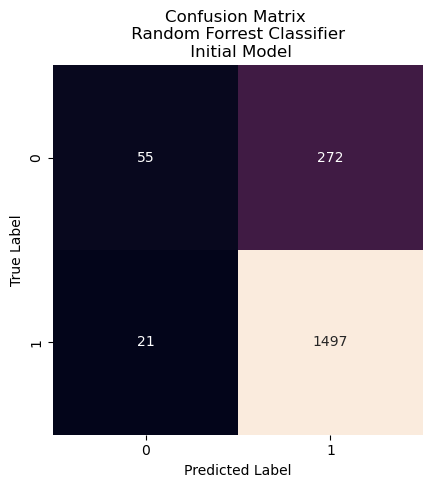

In [36]:
# Confusion Matrix for Random Forest CLassifier Initial Model
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

cm = confusion_matrix(y_test, y_pred_rf_pipeline)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix \n Random Forrest Classifier \n Initial Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Support Vector Machines (SVM)**

Setting up the `SVM` using a pipeline as `model_svm_pipeline` using

using scikit-learn with modules

- make_pipeline
- SVC
- accuracy_score

to train and evaluate the model with accuracy score and confusion matrix.

In [37]:
# `model_svm_pipeline`

model_svm_pipeline = make_pipeline(
    feature_engineering,
    SVC(),
)

model_svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='m...
                                                  Index(['Review Text'], dtype='object')),
                                                 ('tfidf_text',
                                                  Pipeline(steps=[('dimension_reshaper',
                                                                   FunctionTransformer(func=<function reshape at 0x000002421816C870>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x000002421DB1DA00>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  Index(['Review Text'], dtype='object'))])),
                ('svc', SVC())])

In [38]:
# Accuracy SVM Pipeline

y_pred_svm_pipeline = model_svm_pipeline.predict(X_test)
accuracy_svm_pipeline = accuracy_score(y_test, y_pred_svm_pipeline)
precision_svm_pipeline = precision_score(y_test, y_pred_svm_pipeline)
recall_svm_pipeline = recall_score(y_test, y_pred_svm_pipeline)
f1_svm_pipeline = f1_score(y_test, y_pred_svm_pipeline)

print('Accuracy:', accuracy_svm_pipeline)
print('Precision:', precision_svm_pipeline)
print('Recall:', recall_svm_pipeline)
print('F1:', f1_svm_pipeline)

Accuracy: 0.8227642276422764
Precision: 0.8227642276422764
Recall: 1.0
F1: 0.9027653880463872


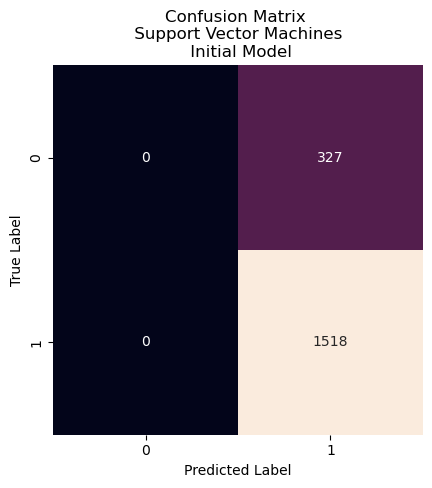

In [39]:
# Confusion Matrix for SVM Initial Model

cm = confusion_matrix(y_test, y_pred_svm_pipeline)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix \n Support Vector Machines \n Initial Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

After training and evaluation there is an accuracy of both models:

- Random Forest Classifier: 84,1% and
- Support Vector Machines: 82,3%.

## Fine-Tuning Pipeline

After that we can fine-tune our models to increase accuracy by adjust parameters. Common methods are `RandomizedSearchCV` and `GridSearchCV`. I choose the `RandomizedSearchCV` method, because it is less time consuming.

After the identification of the best parameters, we can use this fine-tuned model against the test set to observe its performance.

**RandomForestClassifier**

In [40]:
# `Identify model parameters`

model_rf_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'randomforestclassifier', 'columntransformer__force_int_remainder_cols', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__num', 'columntransformer__cat', 'columntransformer__character_counts', 'columntransformer__tfidf_text', 'columntransformer__num__memory', 'columntransformer__num__steps', 'columntransformer__num__verbose', 'columntransformer__num__imputer', 'columntransformer__num__scaler', 'columntransformer__num__imputer__add_indicator', 'columntransformer__num__imputer__copy', 'columntransformer__num__imputer__fill_value', 'columntransformer__num__imputer__keep_empty_features', 'columntransformer__num__imputer__missing_values', 'columntransformer__num__imputer__strategy', 'columntransformer__num__

In [41]:
# Set parameters for `RandomForestClassifier` model

params_rf = dict(
    randomforestclassifier__n_estimators= [10, 50, 100, 200],
    randomforestclassifier__max_features= [2, 4, 6, 8],
    columntransformer__num__scaler__feature_range= [(0, 1), (-1, 1)]
)

In [42]:
# Fine-tune parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

param_search_rf = RandomizedSearchCV(
    estimator=model_rf_pipeline,
    param_distributions=params_rf,
    n_iter=6,
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=3,
    random_state=27,
)

param_search_rf.fit(X_train, y_train)

# Retrieve the best parameters
param_search_rf.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'randomforestclassifier__n_estimators': 10,
 'randomforestclassifier__max_features': 4,
 'columntransformer__num__scaler__feature_range': (-1, 1)}

In [43]:
# Best Estimator for Random Forest Classificator

model_rf_best = param_search_rf.best_estimator_
model_rf_best

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler(feature_range=(-1,
                                                                                               1)))]),
                                                  Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('imputer',
                                                                   Simpl...
                                                                   FunctionTransformer(func=<function reshape at 0x000002421816C870>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x000002424EC6E000>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  Index(['Review Text'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=4, n_estimators=10))])

In [44]:
# Accuracy Metrics RF Pipeline

y_pred_rf_pipeline = model_rf_best.predict(X_test)
accuracy_rf_pipeline = accuracy_score(y_test, y_pred_rf_pipeline)
precision_rf_pipeline = precision_score(y_test, y_pred_rf_pipeline)
recall_rf_pipeline = recall_score(y_test, y_pred_rf_pipeline)
f1_rf_pipeline = f1_score(y_test, y_pred_rf_pipeline)

print('Accuracy:', accuracy_rf_pipeline)
print('Precision:', precision_rf_pipeline)
print('Recall:', recall_rf_pipeline)
print('F1:', f1_rf_pipeline)

Accuracy: 0.8357723577235773
Precision: 0.8517660683265779
Recall: 0.969038208168643
F1: 0.9066255778120185


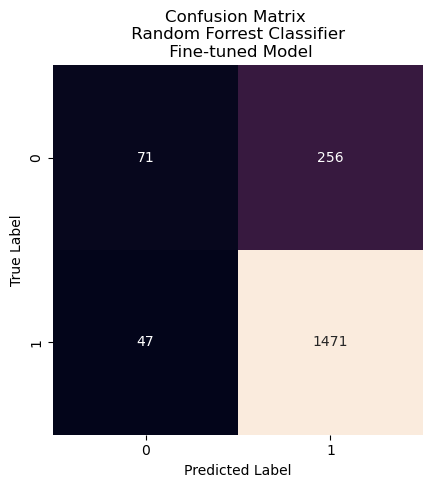

In [45]:
# Confusion Matrix for Random Forest Classifier Fine-tuned Model
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

cm = confusion_matrix(y_test, y_pred_rf_pipeline)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix \n Random Forrest Classifier \n Fine-tuned Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Support Vector Machines**

In [46]:
# Identify model parameters

model_svm_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'svc', 'columntransformer__force_int_remainder_cols', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__num', 'columntransformer__cat', 'columntransformer__character_counts', 'columntransformer__tfidf_text', 'columntransformer__num__memory', 'columntransformer__num__steps', 'columntransformer__num__verbose', 'columntransformer__num__imputer', 'columntransformer__num__scaler', 'columntransformer__num__imputer__add_indicator', 'columntransformer__num__imputer__copy', 'columntransformer__num__imputer__fill_value', 'columntransformer__num__imputer__keep_empty_features', 'columntransformer__num__imputer__missing_values', 'columntransformer__num__imputer__strategy', 'columntransformer__num__scaler__clip', 'col

In [47]:
# Set parameters for SVM model

param_svm = dict(
    svc__C= [1, 10],
    svc__gamma= [0.0001, 0.001],
    svc__kernel= ['linear', 'rbf', 'poly', 'sigmoid']
)

In [48]:
# Fine-tune parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

param_search_svm = RandomizedSearchCV(
    estimator=model_svm_pipeline,
    param_distributions=param_svm,
    n_iter=6,
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=3,
    random_state=27,
)

param_search_svm.fit(X_train, y_train)

# Retrieve the best parameters
param_search_svm.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'svc__kernel': 'linear', 'svc__gamma': 0.001, 'svc__C': 1}

In [49]:
# Best Estimator for SVM Fine-tuned Model

model_svm_best = param_search_svm.best_estimator_
model_svm_best

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='m...
                                                  Pipeline(steps=[('dimension_reshaper',
                                                                   FunctionTransformer(func=<function reshape at 0x000002421816C870>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x0000024241C4BBF0>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  Index(['Review Text'], dtype='object'))])),
                ('svc', SVC(C=1, gamma=0.001, kernel='linear'))])

In [50]:
# Accuracy for SVM Fine-tuned Model

y_pred_svm_pipeline = model_svm_best.predict(X_test)
accuracy_svm_pipeline = accuracy_score(y_test, y_pred_svm_pipeline)
precision_svm_pipeline = precision_score(y_test, y_pred_svm_pipeline)
recall_svm_pipeline = recall_score(y_test, y_pred_svm_pipeline)
f1_svm_pipeline = f1_score(y_test, y_pred_svm_pipeline)

print('Accuracy:', accuracy_svm_pipeline)
print('Precision:', precision_svm_pipeline)
print('Recall:', recall_svm_pipeline)
print('F1:', f1_svm_pipeline)


Accuracy: 0.8829268292682927
Precision: 0.9104665825977302
Recall: 0.9512516469038208
F1: 0.9304123711340206


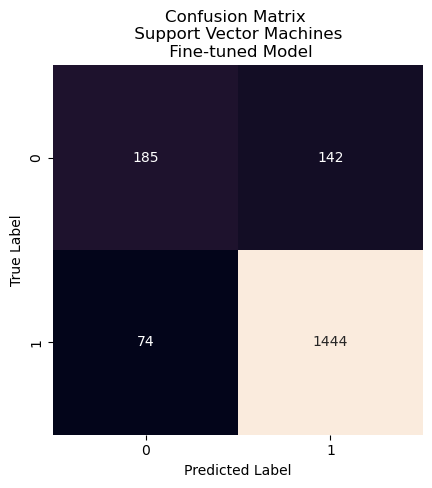

In [51]:
# Confusion Matrix for SVM Fine-tuned Model

cm = confusion_matrix(y_test, y_pred_svm_pipeline)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix \n Support Vector Machines \n Fine-tuned Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The fine-tunig step increased the accuracy of at least the SVM model

- Random Forest Classifier: 84,1% -> 83,5%
- Support Vector Machines: 82,3% -> 88,3%

In [52]:
# Show parameters of the model with the most accuracy

model_svm_best.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', MinMaxScaler())]),
                                    Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                   ('cat',
                                    Pipeline(steps=[('ordinal_encoder',
                                                     OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                    unknown_value=-1)),
                                                    ('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('cat_encoder',
                                                     OneHot...
                                    Index(['Review